##### Imports

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import seaborn as sns
import scipy.optimize
from IPython.display import display, display_markdown
from numpy.lib.stride_tricks import sliding_window_view

In [46]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Experiment

## Load data

In [47]:
curls_df = pd.read_csv("./data/sam/Curls_3x10_7kg-2024-01-25_16-55-30/TotalAcceleration.csv")
squat_df = pd.read_csv("./data/sam/Squats_3x8_7kg-2024-01-25_17-00-38/TotalAcceleration.csv")
curls_df

,time,seconds_elapsed,y,z,x,hypothesis
0,1.706202e+18,0.252757,-7.177817,6.464345,0.991199,NaN
1,1.706202e+18,0.274439,-7.551312,6.133945,1.216254,NaN
2,1.706202e+18,0.290274,-7.771579,5.315128,1.273715,NaN
3,1.706202e+18,0.306591,-8.087613,5.238513,0.900220,NaN
4,1.706202e+18,0.316342,-8.240842,5.722142,1.297657,NaN
...,...,...,...,...,...,...
3308,1.706202e+18,36.236247,1.015141,7.556100,7.144298,NaN
3309,1.706202e+18,36.246292,0.588974,7.513005,7.407660,NaN
3310,1.706202e+18,36.256083,0.378284,7.235278,6.971915,NaN
3311,1.706202e+18,36.266168,0.756568,7.163452,6.296751,NaN


## Trim data to relevant periods

Data is trimmed so that it starts at the beginning of the first rep and ends at the end of the last rep.

|Exercise|Reps|Weight|
|-|-|-|
|Curls|10|7kg dumbbells|
|Squats|8|7kg dumbbells|

In [48]:
# Plot x, y and z values on a line for curl_df
def plot_accelerometer(df):
    fig = plt.figure(figsize=(50, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Time elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

def plot_accelerometer_hyp(df):
    fig = plt.figure(figsize=(50, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Time elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

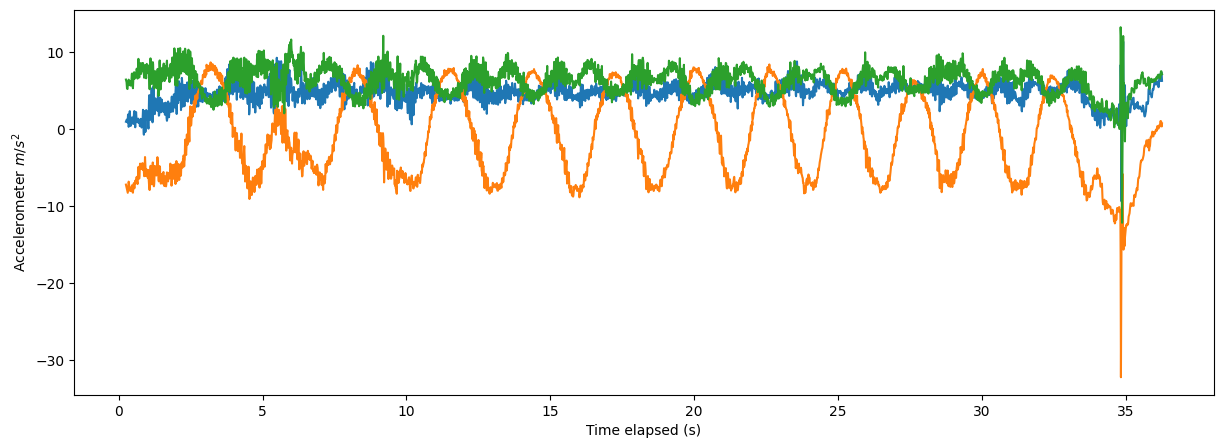

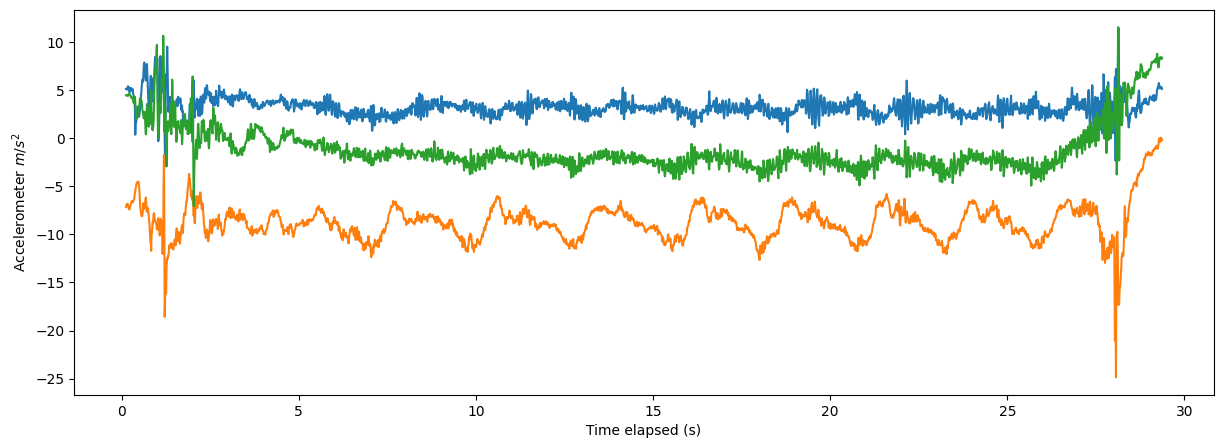

In [49]:
plot_accelerometer(curls_df)
plot_accelerometer(squat_df)

In [50]:
# Trim curls to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
curls_df_start = curls_df[curls_df["seconds_elapsed"] == 7.0367890625].index[0]
curls_df_end = curls_df[curls_df["seconds_elapsed"] == 33.48751904296875].index[0]
curls_df_trim = curls_df.iloc[curls_df_start:curls_df_end, :]

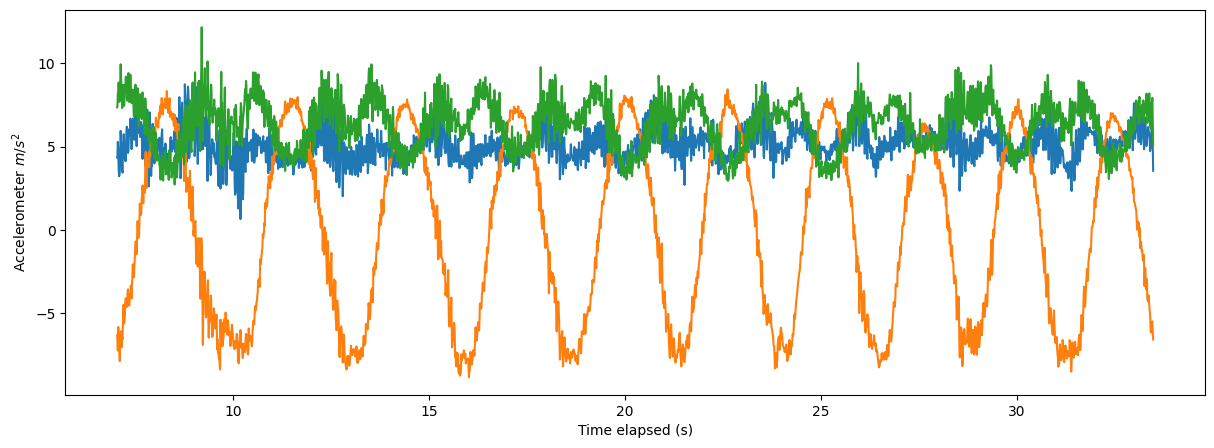

In [51]:
plot_accelerometer(curls_df_trim)

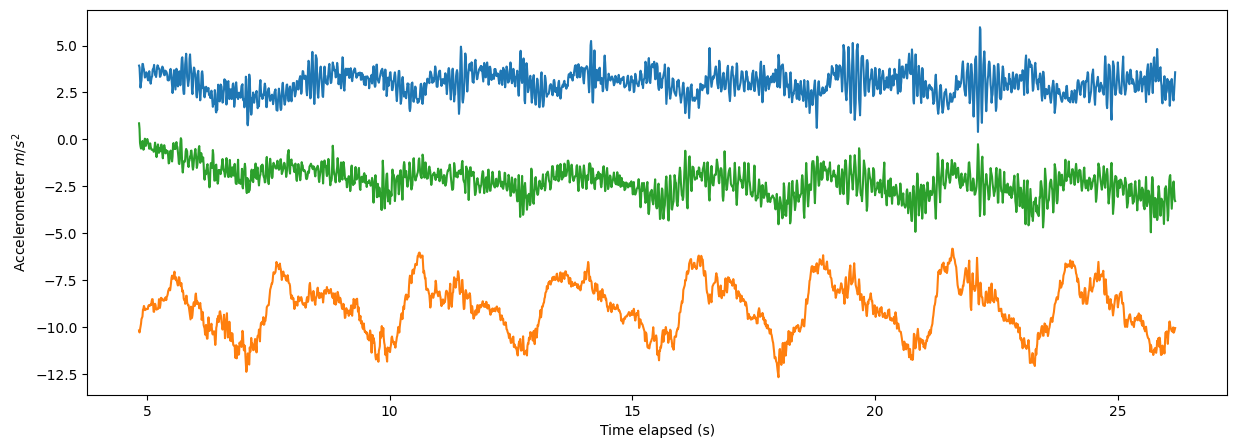

In [52]:
# Trim squats to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
squat_df_start = squat_df[squat_df["seconds_elapsed"] == 4.837999267578125].index[0] #4.83
squat_df_end = squat_df[squat_df["seconds_elapsed"] == 26.19851220703125].index[0] #26.19
squat_df_trim = squat_df.iloc[squat_df_start:squat_df_end, :]
plot_accelerometer(squat_df_trim)

## Label data

Periods in the data representing certain motions are manually marked with the appropriate hypothesis.

|Exercise|Part|Hypothesis|
|-|-|-|
|Curls|Raising movement|$\mathcal{H}_0$|
|Curls|Lowering movement|$\mathcal{H}_0$|
|Curls|Motionless period between reps|$\mathcal{H}_0$|
|Squats|Raising movement|$\mathcal{H}_1$|
|Squats|Lowering movement|$\mathcal{H}_1$|
|Squats|Motionless period between reps|$\mathcal{H}_0$|

### Set true hypotheses on trimmed data

#### Curls
This looks stupid but might have value as a control case?

In [53]:
curls_df_trim.loc[:, 'hypothesis'] = 0
# ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"])

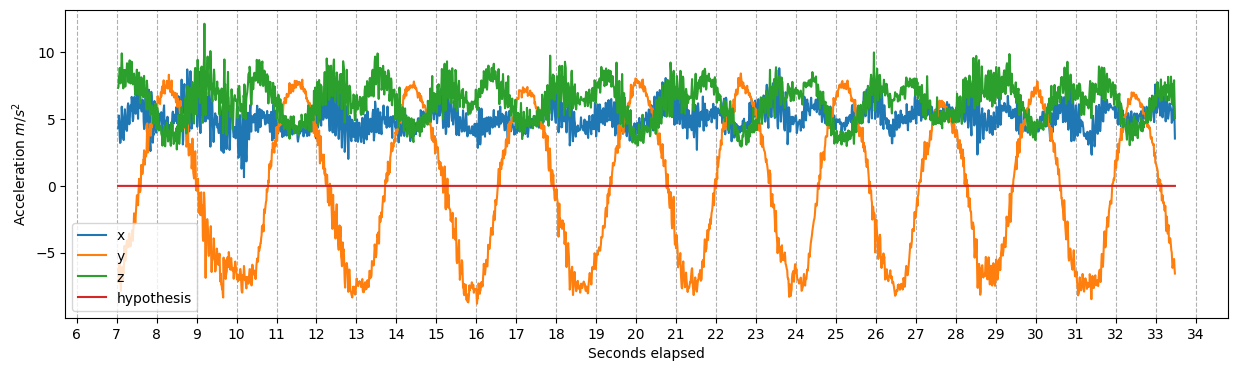

In [58]:
# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(15, 4))
plt.xlabel("Seconds elapsed")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["x"], label="x")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["y"], label="y")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["z"], label="z")
ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"], label="hypothesis")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a= plt.xticks(np.arange(6, 35, 1))

#### Squats

In [ ]:
squat_df_trim["seconds_elapsed"] >= 0

464     True
465     True
466     True
467     True
468     True
        ... 
2389    True
2390    True
2391    True
2392    True
2393    True
Name: seconds_elapsed, Length: 1930, dtype: bool

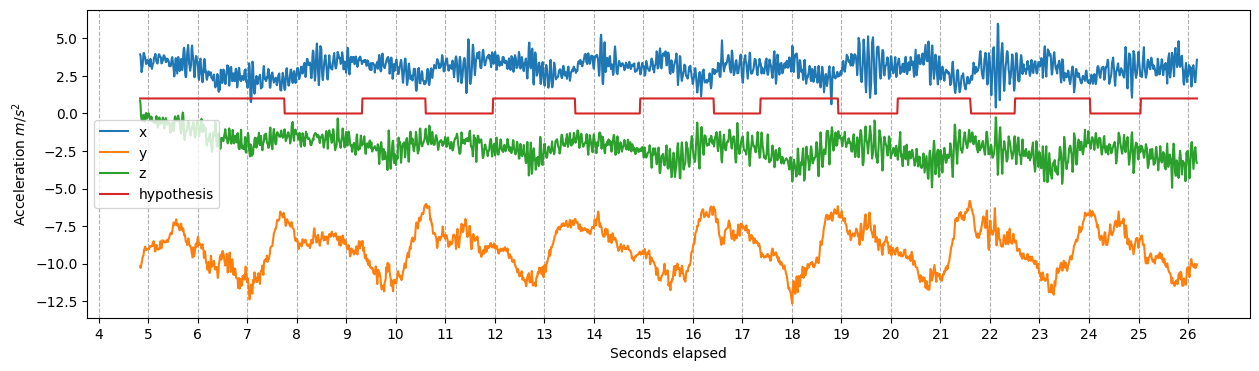

In [ ]:
# Motionless end   - idx 0
# Bottom of rep 1  - 7.03787s - H1 - 7.037873779296875
# Top of rep 1     - 7.75819s - H1 - 7.75818505859375
# Motionless end 1 - 9.32852s - H0 - 9.328517822265624
# Bottom of rep 2  - 9.76746s - H1 - 9.7674619140625
# Top of rep 2     - 10.5975s - H1 - 10.597513916015625
# Motionless end 2 - 11.9576s - H0 - 11.957637939453125
# Bottom of rep 3  - 12.7275s - H1 - 12.727472900390625
# Top of rep 3     - 13.618s  - H1 - 13.618012939453125
# Motionless end 3 - 14.9384s - H0 - 14.93835205078125
# Bottom of rep 4  - 15.8475s - H1 - 15.8475068359375
# Top of rep 4     - 16.4283s - H1 - 16.428326904296874
# Motionless end 4 - 17.368s  - H0 - 17.36797705078125
# Bottom of rep 5  - 18.2379s - H1 - 18.237943115234376
# Top of rep 5     - 18.938s  - H1 - 18.938011962890624
# Motionless end 5 - 20.1391s - H0 - 20.139137939453125
# Bottom of rep 6  - 21.0387s - H1 - 21.03868115234375
# Top of rep 6     - 21.6189s - H1 - 21.618908935546877
# Motionless end 6 - 22.5000s - H0 - 22.507530029296873
# Bottom of rep 6  - 23.2380s - H1 - 23.2380419921875
# Top of rep 7     - 24.0281s - H1 - 24.028087158203125
# Motionless end 7 - 25.0486s - H0 - 25.048609130859376
# Bottom of rep 8  - 25.7177s - H1 - 25.71772119140625
# Top of rep 8     - 26.7175s - H1 - 26.717465087890623
# Motionless end 8 - 27.5377s - H0 - 27.537717041015625

conds = [
    (squat_df_trim["seconds_elapsed"] >= 0.0)                & (squat_df_trim["seconds_elapsed"] < 7.037873779296875),
    (squat_df_trim["seconds_elapsed"] >= 7.037873779296875) & (squat_df_trim["seconds_elapsed"] < 7.75818505859375),
    (squat_df_trim["seconds_elapsed"] >= 7.75818505859375) & (squat_df_trim["seconds_elapsed"] < 9.328517822265624),
    (squat_df_trim["seconds_elapsed"] >= 9.328517822265624) & (squat_df_trim["seconds_elapsed"] < 9.7674619140625),
    (squat_df_trim["seconds_elapsed"] >= 9.7674619140625) & (squat_df_trim["seconds_elapsed"] < 10.597513916015625),
    (squat_df_trim["seconds_elapsed"] >= 10.597513916015625) & (squat_df_trim["seconds_elapsed"] < 11.957637939453125),
    (squat_df_trim["seconds_elapsed"] >= 11.957637939453125) & (squat_df_trim["seconds_elapsed"] < 12.727472900390625),
    (squat_df_trim["seconds_elapsed"] >= 12.727472900390625) & (squat_df_trim["seconds_elapsed"] < 13.618012939453125),
    (squat_df_trim["seconds_elapsed"] >= 13.618012939453125) & (squat_df_trim["seconds_elapsed"] < 14.93835205078125),
    (squat_df_trim["seconds_elapsed"] >= 14.93835205078125) & (squat_df_trim["seconds_elapsed"] < 15.8475068359375),
    (squat_df_trim["seconds_elapsed"] >= 15.8475068359375) & (squat_df_trim["seconds_elapsed"] < 16.428326904296874),
    (squat_df_trim["seconds_elapsed"] >= 16.428326904296874) & (squat_df_trim["seconds_elapsed"] < 17.36797705078125),
    (squat_df_trim["seconds_elapsed"] >= 17.36797705078125) & (squat_df_trim["seconds_elapsed"] < 18.237943115234376),
    (squat_df_trim["seconds_elapsed"] >= 18.237943115234376) & (squat_df_trim["seconds_elapsed"] < 18.938011962890624),
    (squat_df_trim["seconds_elapsed"] >= 18.938011962890624) & (squat_df_trim["seconds_elapsed"] < 20.139137939453125),
    (squat_df_trim["seconds_elapsed"] >= 20.139137939453125) & (squat_df_trim["seconds_elapsed"] < 21.03868115234375),
    (squat_df_trim["seconds_elapsed"] >= 21.03868115234375) & (squat_df_trim["seconds_elapsed"] < 21.618908935546877),
    (squat_df_trim["seconds_elapsed"] >= 21.618908935546877) & (squat_df_trim["seconds_elapsed"] < 22.507530029296873),
    (squat_df_trim["seconds_elapsed"] >= 22.507530029296873) & (squat_df_trim["seconds_elapsed"] < 23.2380419921875),
    (squat_df_trim["seconds_elapsed"] >= 23.2380419921875)& (squat_df_trim["seconds_elapsed"] < 24.028087158203125),
    (squat_df_trim["seconds_elapsed"] >= 24.028087158203125) & (squat_df_trim["seconds_elapsed"] < 25.048609130859376),
    (squat_df_trim["seconds_elapsed"] >= 25.048609130859376) & (squat_df_trim["seconds_elapsed"] < 25.71772119140625),
    (squat_df_trim["seconds_elapsed"] >= 25.71772119140625) & (squat_df_trim["seconds_elapsed"] < 26.717465087890623),
    (squat_df_trim["seconds_elapsed"] >= 26.717465087890623) & (squat_df_trim["seconds_elapsed"] < 27.537717041015625),
]

values = [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0]
true_hyps = np.select(conds, values)
squat_df_trim.loc[:, 'hypothesis'] = true_hyps

# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(15, 4))
plt.xlabel("Seconds elapsed")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["x"], label="x")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["y"], label="y")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["z"], label="z")
ax = plt.plot(squat_df_trim["seconds_elapsed"], np.select(conds, values), label="hypothesis")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a= plt.xticks(np.arange(4, 27, 1))

## Compute test statistics for data

In [ ]:
def SSM(vector):
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def calc_min_ev(alpha_beta_gamma: tuple[3], y):
    """Calculate the minimum eigenvalue
    This function will be minimized on the direction of gravity

    y is a sliding window about a certain measurement"""
    u_g = np.array(alpha_beta_gamma)
    g = 9.81

    M = np.zeros((3, 3))
    for y_k in y:  # [x, y, z]
        measurement = y_k + (g * u_g)
        M += SSM(measurement).T * SSM(measurement)

    if np.isnan(np.ravel(M)).any():
        return 9999999999999999999

    eigvs, _ = np.linalg.eig(M)
    return min(eigvs)

In [ ]:
def optimise_u_g(y, guess=(0.1, 0.1, 0.1)):
    """Use scipy to optimise the alpha and beta for the best min eig"""
    res = scipy.optimize.minimize(
        fun=calc_min_ev,
        x0=guess,
        args=(y,),
        constraints=[{"type": "eq", "fun": lambda x: np.sum(np.array(x)**2) - 1}],
        method="trust-constr",
    )
    return res

In [ ]:
def decide_on_hypothesis(test_statistics, gamma):
    """Decide on hypothesis at each point."""
    return test_statistics > gamma

def calculate_acc(decisions, true_hyps):
    """Calculate the proportion of decisions that were *correct*."""
    return np.mean(decisions == true_hyps)

def calculate_error(decisions, true_hyps):
    """Calculate the proportion of decisions that were *wrong*."""
    return np.mean(decisions != true_hyps)

def plot_hypotheses(x, hypotheses, s=None):
    plt.xlabel("Seconds elapsed (s)")
    plt.ylabel("Hypothesis")
    plt.yticks([0, 1])
    plt.ylim(-0.1, 1.1)
    ax = plt.scatter(x, hypotheses, s=s)
    return ax

In [ ]:
def measurement_window(measurements, n, stride=1):
    """
    Create sliding windows of size 'n' from the measurements data.

    Parameters:
    measurements (DataFrame): The input measurements data.
    n (int): The size of the sliding window.
    stride (int, optional): The stride value for the sliding window. Defaults to 1.

    Returns:
    ndarray: The sliding windows of size 'n' from the measurements data.
    """
    x_sw = sliding_window_view(measurements["x"].to_numpy(), n)
    y_sw = sliding_window_view(measurements["y"].to_numpy(), n)
    z_sw = sliding_window_view(measurements["z"].to_numpy(), n)

    # Combine x, y and z into 3D vectors for each measurement in the sliding window
    sw = np.stack((x_sw, y_sw, z_sw), axis=-1)
    return sw[::stride]

# sw_100[k] is the kth window of 100 measurements
# sw_100[k][j] is the jth measurement in the kth window
# sw_100[k][j][i] is the ith coordinate of the jth measurement in the kth window

In [ ]:
def min_min_evs(windows):
    Ts = []  # min min eigs

    for window in windows:
        res = optimise_u_g(window)
        min_min_ev = res.fun
        Ts.append(min_min_ev)

    return Ts

### What do the test statistics (minimum minimum eigenvalues) look like?

#### Calculate min min eigenvalues

In [ ]:
squat_window_stride = 10
squat_window_size = 100
curl_window_stride = 10
curl_window_size = 100

In [ ]:
# POINTLESS? Truncate dataframe to length of data to nearest multiple of window size
squat_df_trim_t = squat_df_trim.iloc[
    : len(squat_df_trim) - len(squat_df_trim) % squat_window_size, :
]
curls_df_trim_t = curls_df_trim.iloc[
    : len(curls_df_trim) - len(curls_df_trim) % curl_window_size, :
]
display(squat_df_trim_t[::10].shape)
display(curls_df_trim_t[::10].shape)

(190, 6)

(240, 6)

In [ ]:
# squat_Ts = min_min_evs(measurement_window(squat_df_trim, squat_window_size, stride=squat_window_stride))
squat_Ts = pd.read_csv("data/sam/squat_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [ ]:
# curl_Ts = min_min_evs(measurement_window(curls_df_trim_t, curl_window_size, stride=curl_window_stride))
curl_Ts = pd.read_csv("./data/sam/curl_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [ ]:
print("Squats")
print(squat_df_trim["hypothesis"][::squat_window_stride].shape)
print(pd.Series(squat_Ts).shape)

print()

print("Curls")
print(curls_df_trim["hypothesis"][::curl_window_stride].shape)
print(pd.Series(curl_Ts).shape)

Squats
(193,)
(184,)

Curls
(241,)
(231,)


In [ ]:
squat_Ts_df = pd.DataFrame(squat_Ts, columns=["T"])
curls_Ts_df = pd.DataFrame(curl_Ts, columns=["T"])

#squat_Ts_df["seconds_elapsed"] = squat_df_trim["seconds_elapsed"].iloc[::squat_window_stride].values
#curls_Ts_df["seconds_elapsed"] = curls_df_trim["seconds_elapsed"].iloc[::curl_window_stride].values

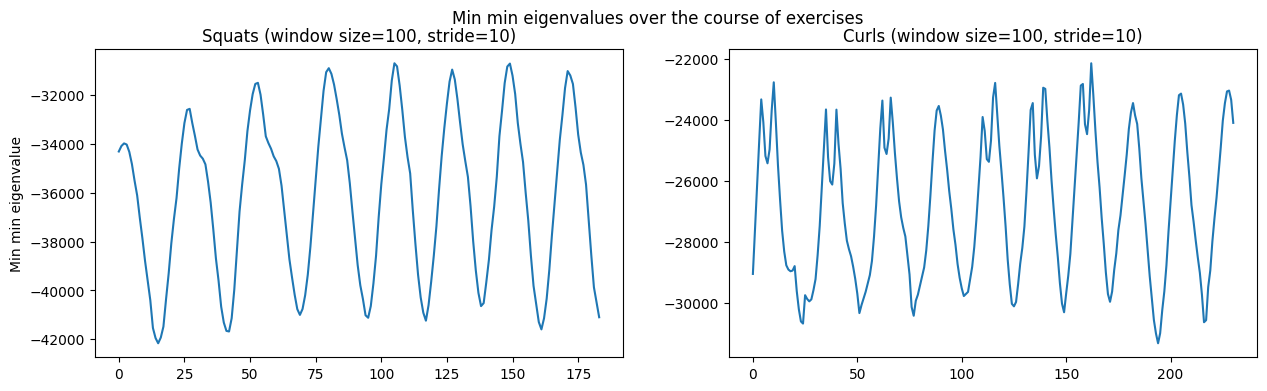

In [ ]:
# Exploratory eigenvalue plot
plt.figure(figsize=(15, 4))
plt.suptitle("Min min eigenvalues over the course of exercises")

plt.subplot(1, 2, 1)
plt.title(f"Squats (window size={squat_window_size}, stride={squat_window_stride})")
plt.ylabel("Min min eigenvalue")
ax = pd.Series(squat_Ts).plot()

plt.subplot(1, 2, 2)
plt.title(f"Curls (window size={curl_window_size}, stride={curl_window_stride})")
ax = pd.Series(curl_Ts).plot()

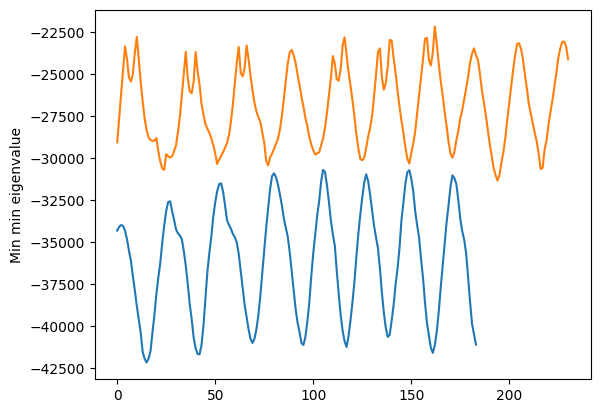

In [ ]:
plt.ylabel("Min min eigenvalue")
ax = pd.Series(squat_Ts).plot()
ax = pd.Series(curl_Ts).plot()

Clear separation visible

# To do
- actual classification step
- more window sizes
- ROC curve
- dump all that doesnt fit into a window
- still data - translation

- extend - third hypothesis for not moving at all
- Try with more motions to see if separation still present?

# Draft sending deadline: a week before

### Deciding on hypotheses

In [ ]:
def side_by_side_hyps(x, y1, y2, left, right):
    """Plot two sets of hypotheses side by side."""
    plt.figure(figsize=(15, 4))

    plt.subplot(2, 1, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.xticks(np.arange(left, right, 1))
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=1)

    plt.subplot(2, 1, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.xticks(np.arange(left, right, 1))
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=1, color="tab:orange")
    plt.xlabel("Seconds elapsed (s)")
    return ax1, ax2

In [ ]:
def grid_search_gammas(Ts, true_hyps, left, right, step):
    """Grid search for the best gamma."""
    gammas = np.arange(left, right, step)
    accs = []
    errs = []

    for gamma in gammas:
        decisions = decide_on_hypothesis(Ts, gamma)
        acc = calculate_acc(decisions, true_hyps)
        err = calculate_error(decisions, true_hyps)
        accs.append(acc)
        errs.append(err)

    return gammas, accs, errs

In [ ]:
grid_search_gammas(squat_Ts, squat_df_trim["hypothesis"][::squat_window_stride], -6_000, 6_000, 200)

ValueError: ('Lengths must match to compare', (193,), (184,))